# ONCOANALYSER-SAGE VCF PROCESSING MELANOMA SAMPLE TO CALCULATE VAF

# 1/ Reading the vcf files and formating as dataframe

In [45]:
# Needed basic packages
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib_venn import venn2
import pandas as pd

In [46]:
# IMPORT THE VCF files WITH THE comment function IN PANDAS:

# With "comment" option goes directly to the row after "#" where the vcf body starts

# Note that SAGE delivers a filtered mutation file and another with all mutations including those that did not passed filters! So importing the filtered file avoids filtering "PASS" mutations

sage_df = pd.read_csv("/workspace/projects/sjd_melos/var_call_output/oncoanalyser_results/output/patient1_grp2/sage/somatic/AX4967.sage.somatic.filtered.vcf.gz", sep = "\t", comment='#', header=None)

In [47]:
# Check dimensions of the file
print('Columns x rows in file:',sage_df.shape)

Columns x rows in file: (21809, 11)


In [48]:
# Rename columns of the dataframes according to VCF nomenclature

sage_df.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'NORMAL', 'TUMOR']
sage_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR
0,chr1,104188,.,C,A,644,PASS,RC=TAAACACACACG;RC_IDX=2;RC_LF=CACACACACA;RC_N...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:197,0:0:197:6097,0:206,0:0,0,0,0,0,197,1...","./.:30:162,53:0.245:216:5354,1713:176,57:41,6,..."
1,chr1,843320,.,G,A,1733,PASS,LPS=1;LPS_RC=8;RC=GAAACA;RC_IDX=3;RC_LF=CAAAGA...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:125,0:0:125:3974,0:127,0:0,0,0,0,0,125,1...","./.:31:67,69:0.507:136:2111,2242:68,71:52,15,1..."
2,chr1,1118520,.,C,T,941,PASS,RC=TGTGA;RC_IDX=2;RC_LF=GACGAGGCCA;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:148,0:0:148:4278,0:155,0:0,0,0,0,0,148,1...","./.:31:98,45:0.315:143:2655,1432:100,45:40,4,0..."
3,chr1,1136548,.,G,T,2201,PASS,RC=CATCC;RC_IDX=2;RC_LF=GCTGAGTGGC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:124,0:0:124:3979,0:128,0:0,0,0,0,0,124,1...","./.:30:54,89:0.622:143:1762,2764:56,91:78,10,0..."
4,chr1,1182738,.,C,T,738,PASS,RC=GGTGTGTGG;RC_IDX=2;RC_LF=GCTGGGGCCA;RC_NM=1...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:159,0:0:159:4649,0:173,0:0,0,0,0,0,159,1...","./.:29:102,40:0.282:142:2900,1241:110,42:35,4,..."


### A. Find the number of reads and depth and create new columns with this information

In [49]:
# Check the header information of the VCF file to find this information and GATK manual information: https://gatk.broadinstitute.org/hc/en-us/articles/360035531692-VCF-Variant-Call-Format

# 1/ Split sample of interest info from column using ":" separator and add in new columns in the tumor sample
sage_df = pd.concat([sage_df, sage_df['TUMOR'].str.split(':', expand=True)], axis=1)

# 2/ Rename new columns according to FORMAT column in original data in the tumor sample
sage_df = sage_df.rename(columns={0:'t_GT', 1: 't_ABQ', 2:'t_AD', 3: 't_AF', 4: 't_DP', 5:'t_RABQ', 6:'t_RAD', 7:'t_RC_CNT', 8:'t_RC_IPC', 9:'t_RC_JIT', 10:'t_RC_QUAL', 11:'t_RDP',12:'t_SB'})

In [50]:
# Now for the normal sample
# 1/ Split sample of interest info from column using ":" separator and add in new columns
sage_df = pd.concat([sage_df, sage_df['NORMAL'].str.split(':', expand=True)], axis=1)

# 2/ Rename new columns according to FORMAT column in original data 
sage_df = sage_df.rename(columns={0:'n_GT', 1: 'n_ABQ', 2:'n_AD', 3: 'n_AF', 4: 'n_DP', 5:'n_RABQ', 6:'n_RAD', 7:'n_RC_CNT', 8:'n_RC_IPC', 9:'n_RC_JIT', 10:'n_RC_QUAL', 11:'n_RDP',12:'n_SB'})

In [51]:
# Add SAMPLE name
sage_df = sage_df.assign(SAMPLE='sarcoma')

# Saving this table as a CSV file in directory project
# sage_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_SAGE_passedmut.tsv.gz', sep ='\t', index=None, compression = "gzip")

In [52]:
sage_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,n_DP,n_RABQ,n_RAD,n_RC_CNT,n_RC_IPC,n_RC_JIT,n_RC_QUAL,n_RDP,n_SB,SAMPLE
0,chr1,104188,.,C,A,644,PASS,RC=TAAACACACACG;RC_IDX=2;RC_LF=CACACACACA;RC_N...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:197,0:0:197:6097,0:206,0:0,0,0,0,0,197,1...",...,197,"6097,0","206,0","0,0,0,0,0,197,197",0,"0,0,0","0,0,0,0,0,2309,2309",206,0.5,sarcoma
1,chr1,843320,.,G,A,1733,PASS,LPS=1;LPS_RC=8;RC=GAAACA;RC_IDX=3;RC_LF=CAAAGA...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:125,0:0:125:3974,0:127,0:0,0,0,0,0,125,1...",...,125,"3974,0","127,0","0,0,0,0,0,125,125",0,"0,0,0","0,0,0,0,0,3808,3808",127,0.5,sarcoma
2,chr1,1118520,.,C,T,941,PASS,RC=TGTGA;RC_IDX=2;RC_LF=GACGAGGCCA;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:148,0:0:148:4278,0:155,0:0,0,0,0,0,148,1...",...,148,"4278,0","155,0","0,0,0,0,0,148,148",0,"0,0,0","0,0,0,0,0,4126,4126",155,0.5,sarcoma
3,chr1,1136548,.,G,T,2201,PASS,RC=CATCC;RC_IDX=2;RC_LF=GCTGAGTGGC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:124,0:0:124:3979,0:128,0:0,0,0,0,0,124,1...",...,124,"3979,0","128,0","0,0,0,0,0,124,124",0,"0,0,0","0,0,0,0,0,3119,3119",128,0.5,sarcoma
4,chr1,1182738,.,C,T,738,PASS,RC=GGTGTGTGG;RC_IDX=2;RC_LF=GCTGGGGCCA;RC_NM=1...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:159,0:0:159:4649,0:173,0:0,0,0,0,0,159,1...",...,159,"4649,0","173,0","0,0,0,0,0,159,159",0,"0,0,0","0,0,0,0,0,4099,4099",173,0.5,sarcoma


In [53]:
# Modify again the table so it contains only relevant information

vaf_sage_df = sage_df.drop(['t_GT', 't_ABQ', 't_RABQ', 't_RAD', 't_RC_CNT', 't_RC_IPC', 't_RC_JIT', 't_RC_QUAL', 't_RDP', 't_SB', 'n_GT', 'n_ABQ', 'n_RABQ', 'n_RAD', 'n_RC_CNT', 'n_RC_IPC', 'n_RC_JIT', 'n_RC_QUAL', 'n_RDP', 'n_SB'], axis=1)
vaf_sage_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,TUMOR,t_AD,t_AF,t_DP,n_AD,n_AF,n_DP,SAMPLE
0,chr1,104188,.,C,A,644,PASS,RC=TAAACACACACG;RC_IDX=2;RC_LF=CACACACACA;RC_N...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:197,0:0:197:6097,0:206,0:0,0,0,0,0,197,1...","./.:30:162,53:0.245:216:5354,1713:176,57:41,6,...","162,53",0.245,216,"197,0",0,197,sarcoma
1,chr1,843320,.,G,A,1733,PASS,LPS=1;LPS_RC=8;RC=GAAACA;RC_IDX=3;RC_LF=CAAAGA...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:125,0:0:125:3974,0:127,0:0,0,0,0,0,125,1...","./.:31:67,69:0.507:136:2111,2242:68,71:52,15,1...","67,69",0.507,136,"125,0",0,125,sarcoma
2,chr1,1118520,.,C,T,941,PASS,RC=TGTGA;RC_IDX=2;RC_LF=GACGAGGCCA;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:148,0:0:148:4278,0:155,0:0,0,0,0,0,148,1...","./.:31:98,45:0.315:143:2655,1432:100,45:40,4,0...","98,45",0.315,143,"148,0",0,148,sarcoma
3,chr1,1136548,.,G,T,2201,PASS,RC=CATCC;RC_IDX=2;RC_LF=GCTGAGTGGC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:124,0:0:124:3979,0:128,0:0,0,0,0,0,124,1...","./.:30:54,89:0.622:143:1762,2764:56,91:78,10,0...","54,89",0.622,143,"124,0",0,124,sarcoma
4,chr1,1182738,.,C,T,738,PASS,RC=GGTGTGTGG;RC_IDX=2;RC_LF=GCTGGGGCCA;RC_NM=1...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:159,0:0:159:4649,0:173,0:0,0,0,0,0,159,1...","./.:29:102,40:0.282:142:2900,1241:110,42:35,4,...","102,40",0.282,142,"159,0",0,159,sarcoma


### B. Variant allele frequency information

In [54]:
# According to sage manual AF column contains the Allelic Frequency (=AD[1] / DP), where AD[1] refers to Allelic Depth of reference and alternative alleles.
# So AF is equal to VAF (you can check by dividing AD second comma-separated value by DP!)
# Duplicate this column to create a new "VAF" column to avoid confusion
vaf_sage_df['VAF'] = vaf_sage_df.loc[:, 't_AF'].astype(float)

In [55]:
# Split AD columns in normal and tumor samples to obtain ref/alt reads in samples
vaf_sage_df[['t_ref_reads', 't_alt_reads']] = vaf_sage_df['t_AD'].str.split(',', expand=True)
vaf_sage_df[['n_ref_reads', 'n_alt_reads']] = vaf_sage_df['n_AD'].str.split(',', expand=True)
vaf_sage_df = vaf_sage_df.drop(['t_AD','n_AD'], axis=1)

In [56]:
# Apply function to discriminate mutation type (SAGE detects MNVs like Mutect2)
def muttype_SAGE(row):
    # Infer mutation type
    if len(row['ALT']) != len(row['REF']):
        return 'INDEL'
    elif len(row['ALT']) == len(row['REF']) and len(row['REF']) > 1:
        return 'MNV'
    else:
        return 'SNV'

vaf_sage_df['mut_type'] = vaf_sage_df.apply(muttype_SAGE, axis=1)

In [57]:
vaf_sage_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NORMAL,...,t_DP,n_AF,n_DP,SAMPLE,VAF,t_ref_reads,t_alt_reads,n_ref_reads,n_alt_reads,mut_type
0,chr1,104188,.,C,A,644,PASS,RC=TAAACACACACG;RC_IDX=2;RC_LF=CACACACACA;RC_N...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:197,0:0:197:6097,0:206,0:0,0,0,0,0,197,1...",...,216,0,197,sarcoma,0.245,162,53,197,0,SNV
1,chr1,843320,.,G,A,1733,PASS,LPS=1;LPS_RC=8;RC=GAAACA;RC_IDX=3;RC_LF=CAAAGA...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:125,0:0:125:3974,0:127,0:0,0,0,0,0,125,1...",...,136,0,125,sarcoma,0.507,67,69,125,0,SNV
2,chr1,1118520,.,C,T,941,PASS,RC=TGTGA;RC_IDX=2;RC_LF=GACGAGGCCA;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:148,0:0:148:4278,0:155,0:0,0,0,0,0,148,1...",...,143,0,148,sarcoma,0.315,98,45,148,0,SNV
3,chr1,1136548,.,G,T,2201,PASS,RC=CATCC;RC_IDX=2;RC_LF=GCTGAGTGGC;RC_NM=1;RC_...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:124,0:0:124:3979,0:128,0:0,0,0,0,0,124,1...",...,143,0,124,sarcoma,0.622,54,89,124,0,SNV
4,chr1,1182738,.,C,T,738,PASS,RC=GGTGTGTGG;RC_IDX=2;RC_LF=GCTGGGGCCA;RC_NM=1...,GT:ABQ:AD:AF:DP:RABQ:RAD:RC_CNT:RC_IPC:RC_JIT:...,"./.:0:159,0:0:159:4649,0:173,0:0,0,0,0,0,159,1...",...,142,0,159,sarcoma,0.282,102,40,159,0,SNV


In [58]:
# Check column order
for col in vaf_sage_df.columns:
    print(col)

CHROM
POS
ID
REF
ALT
QUAL
FILTER
INFO
FORMAT
NORMAL
TUMOR
t_AF
t_DP
n_AF
n_DP
SAMPLE
VAF
t_ref_reads
t_alt_reads
n_ref_reads
n_alt_reads
mut_type


In [59]:
# Reorder columns
vaf_sage_df.insert(12, 'n_AF', vaf_sage_df.pop('n_AF'))
vaf_sage_df.insert(21, 'SAMPLE', vaf_sage_df.pop('SAMPLE'))
vaf_sage_df.insert(19, 'VAF', vaf_sage_df.pop('VAF'))
vaf_sage_df.insert(16, 'n_ref_reads', vaf_sage_df.pop('n_ref_reads'))

In [60]:
# saving this table a TSV file in directory project
# vaf_sage_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_SAGE_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")

### C. Disgregate SNV, MNV and INDEL mutations

In [61]:
# Extract data mut_type from mutect_df to discriminate between SNV and INDELS
vaf_sage_snv_df = vaf_sage_df.query("mut_type == 'SNV' | mut_type == 'MNV'")
vaf_sage_indels_df = vaf_sage_df.query("mut_type == 'INDEL'")

In [62]:
# Export the list of SAGE SNV mutations into a tsv table
# vaf_sage_snv_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_SAGE_snvmnv_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")
# vaf_sage_indels_df.to_csv('/workspace/projects/sjd_melos/MAFs_tables/Sar_SAGE_indels_VAF.tsv.gz', sep ='\t', index=None, compression = "gzip")

# 2/ Represent VAF of SAGE all passed mutations

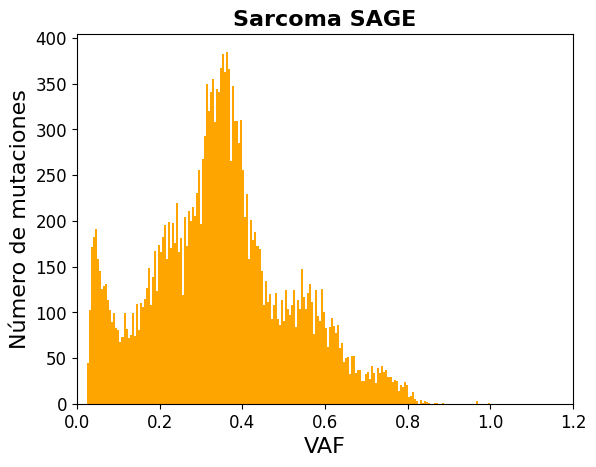

In [63]:
# VAF representation through histogram
plt.hist(vaf_sage_df['VAF'].tolist(), bins = 200, color = "orange")
plt.ylabel('Número de mutaciones', fontsize=16)
plt.xlim([0,1.2]) 
plt.xlabel('VAF', fontsize=16)
plt.title('Sarcoma SAGE', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_sage_sarcoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(vaf_sage_df['VAF'].tolist()) 

# 3/ Represent VAF considering SNPs and INDEL mutations

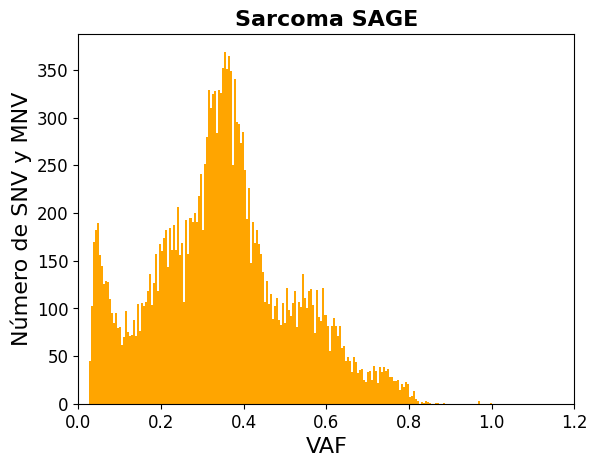

In [64]:
# Now represent VAF of each indel for SNV/INDEL tables obtained above

# For SNV in SAGE
plt.hist(vaf_sage_snv_df['VAF'].tolist(), bins = 200, color = "orange")
plt.xlim([0,1.2])
plt.ylabel('Número de SNV y MNV', fontsize=16)
plt.xlabel('VAF',fontsize=16)
plt.title('Sarcoma SAGE', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_sage_snv_sarcoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(vaf_sage_snv_df['VAF'].tolist())  

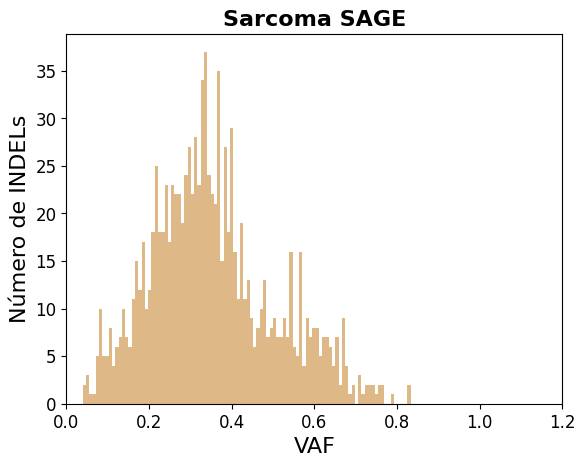

In [65]:
# For INDELs in SAGE

plt.hist(vaf_sage_indels_df['VAF'].tolist(), bins = 100, color = "burlywood")
plt.xlim([0,1.2])
plt.ylabel('Número de INDELs', fontsize=16)
plt.xlabel('VAF', fontsize=16)
plt.title('Sarcoma SAGE', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('/workspace/projects/sjd_melos/exports_images/density_vaf_sage_indels_sarcoma.png',dpi=300,transparent=True, format='png', bbox_inches='tight')
plt.show(vaf_sage_indels_df['VAF'].tolist())  